# Fitness - Metric

### Replay Fitness quantifies the extent to which the model can reproduce the traces recorded in the log.

### The quality dimension of replay Fitness describes the fraction of the behavior in the event log that can be replayed by the process model.

#### Importing Libraries

In [1]:
import os
import configparser
from datetime import date
import pandas as pd
import re
import graphviz
import math
import seaborn as sns
import collections
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
sns.set(style="whitegrid")

from tqdm import tqdm
from tqdm import trange

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

#### Profit Intialization

In [2]:
PATH = 'C:\\Users\\ashis\\Python Notebooks\\ProFIT'# path to ProFIT directory
config = configparser.ConfigParser()
config.add_section("packageLocation")
config.set("packageLocation", "workingDir", PATH)
config.set("packageLocation", "packageDir", PATH+'\\profit')


import sys
sys.path.append(config["packageLocation"]["workingDir"])
sys.path.append(config["packageLocation"]["packageDir"])


from profit import ProcessMap
pm = ProcessMap()

### Net Graph GENERATOR 

In [9]:
def Filter(net):
        temp = str(net)
        temp = temp.lower()
        temp = re.sub("\d",'', temp)
        temp = re.sub('node',' ', temp)
        temp = re.sub('\(', "", temp)
        temp = re.sub('\)', "", temp)
        temp = re.sub('\[', "", temp)
        temp = re.sub('\]', "", temp)
        temp = re.sub('\{', "", temp)
        temp = re.sub('\}', "", temp)
        temp = re.sub('connections',' ', temp)
        temp = re.sub('-', '', temp)
        temp = re.sub(' ','', temp)
        
        temp = re.sub('\:','', temp)
        temp = re.sub('\,',' ', temp)
        temp = re.sub('\'','', temp)
        temp = re.sub('\.','', temp)
        temp = re.sub(' +', '', temp)
        temp = re.sub('"', '', temp)
        return temp

def inner_Filter(net):
        temp = str(net)
        temp = temp.lower()
        temp = re.sub("\d",'', temp)
        temp = re.sub('node',' ', temp)
        temp = re.sub('\(', "", temp)
        temp = re.sub('\)', "", temp)
        temp = re.sub('\[', "", temp)
        temp = re.sub('\]', "", temp)
        temp = re.sub('\{', "", temp)
        temp = re.sub('\}', "", temp)
        temp = re.sub('connections',' ', temp)
        temp = re.sub(' ','', temp)
                
        temp = re.sub('\:',' ', temp)
        temp = re.sub('\,',' ', temp)
        temp = re.sub('\'','', temp)
        temp = re.sub('\.',' ', temp)
        temp = re.sub(' +', ' ', temp)
        temp = re.sub('"', '', temp)
        temp = re.sub('-', "",temp)
        return temp
    
    
def Final(net):
        temp = str(net)
        temp = temp.lower()
        temp = re.sub("\d",'', temp)
        temp = re.sub('node',' ', temp)
        temp = re.sub('\(', "", temp)
        temp = re.sub('\)', "", temp)
        temp = re.sub('\[', "", temp)
        temp = re.sub('\]', "", temp)
        temp = re.sub('\{', "", temp)
        temp = re.sub('\}', "", temp)
        temp = re.sub('connections',' ', temp)
        temp = re.sub(' ','', temp)
        
        temp = re.sub('\:',' ', temp)
        temp = re.sub('\,',' ', temp)
        temp = re.sub('\'',' ', temp)
        temp = re.sub('\.',' ', temp)
        temp = re.sub(' +', ' ', temp)
        temp = re.sub('"', ' ', temp)
        HT = pd.DataFrame([x.split(' ') for x in temp.split('\n')])
        HT = HT.transpose()
        HT = HT.drop([0]).reset_index(drop = True)
        HT.columns = ['Task']
        HT= HT.drop(index=HT.index[-1])
        HT = HT.drop_duplicates(ignore_index=True)
        HT = HT.sort_values("Task").reset_index(drop = True)
        #print(HT)
    
        return HT 
    

    
def MINER(in_data, act, path):

    pm.set_log(data = in_data)
          
    # Have to change "Optimize" State when using Manual Path & Activity Rates
    pm.set_params(optimize = False, aggregate = False) # Optimize = TRUE/FALSE # Agg_type = inner/outer
        
    # Will be activated only when "OPTIMIZE" from above is changed to "False"
    pm.set_rates(activity_rate = act, path_rate = path ) # Rates = Activity & Path rate only 
       
    # Logic on this (or in % , where 100% means complete utilization & 0% Vice Versa) 
    # Activity Rate = The precision/clarity of the model/graph being produced (i.e. when at 100 = all events are displayed, when at 5-10 low number of events with the most highest weightage are displayed)
    # Path rate = the regulation of paths (i.e. aggregation of path in %)0 = high aggregation of path, 100 % super detailed paths to every case/task
        
    pm.update() # Updates settings
        
    #pm.render() # Renders the Final Process Model
        
    print(pm.get_rates())
        
    net = pm.get_graph() # Net Graph GENERATOR
   
    return net   # Returns the Net Graph


def map_2_key(INPUT): # Converts the NET MAP into a Key:Dict Format 
    
    OUTPUT = []
    for key in INPUT:
        OUTPUT.append(key)
        
    return OUTPUT


 
def Key_SEGREGATOR(INPUT): # Seperates the Input into Source & Destination 
    
    OUT_main = []
    OUT_sub = []
    for i in range(len(INPUT)):
        OUT_main.append(inner_Filter(INPUT[i]).split(' ')[0])
        OUT_sub.append(inner_Filter(INPUT[i]).split(' ')[1])  
    
    return (OUT_main, OUT_sub) # Returns 2 Variables Holding Source Events & Destination Activites according to the Process Map





# This Function converts the Mainkey & Subkey into a Source & Destination Format 
# Where Each Source is aligned with its Linked Destinations under a clear Dictionary List format. 
def ONE_D_Mapper(mains, subs): 

    t_i = mains[0]                       # Stores the First Source Event
    k = 0                                # While Counter
    A = collections.defaultdict(list)    # The Empty Dictionary of Lists to store the One Dimensional Map. 

    while k < len(mains):         
                                         # Dynamically create key
        
        if k == 0:                       # Specific to the first Iteration
            key = mains[k] 

        if t_i == mains[k]:              # Specific to the First Iteration 
            value = subs[k]
            A[key].append(value)
            k+=1
            
        else:                            # All the Remaining Iterations follows this piece of code
            
            if t_i != mains[k]:
                t_i = mains[k]
                key = mains[k]
                value = subs[k]
                A[key].append(value)
                k+=1
                
    return A # Returns a Dict List 




# Performs Validation if the Input Traces can be Traveresed throught the Process Model. 
def Wheeler(LOG, MAP):
    
    Flag_1 = 0 # OUTER FLAG (START POINT FLAG)
    Flag_2 = 0 # INNER FLAG (END POINT FLAG)
    
    decider = [] # Resets for Every ID
    
    for m in range(0, len(LOG)-1, 1):
        
        Flag_1 = 0 # OUTER FLAG (START POINT FLAG)
        Flag_2 = 0 # INNER FLAG (END POINT FLAG)
        
        State_1 = LOG["task"][m]    # Present Index 
        State_2 = LOG["task"][m+1]  # Present Index + 1`
        
        for n in range(len(MAP.keys())):
            
            if State_1 == list(MAP.keys())[n]:
                Flag_1 = 1
                Var_State = State_1 # Starting point of the line (INTIAL POINT)
                
                for p in range(len(MAP[Var_State])): # Checking the second state (destination)
                    
                    if State_2 == MAP[Var_State][p]:
                        Flag_2 = 1
                        decider.append(1) # 1 When it is completed 
                        
    return decider # Return a list with 1's only when the Trace has be completely Covered by the Model (this works in realation to the size of the individual Trace)

    
# This function is created to remove the Start & End EVENTS generated when the Process Map is extracted
def START_END_DEL(main, sub): 
    
    SS = pd.DataFrame(sub,main).reset_index()
    SS.columns = ["mainkey", "subkey"]
    
    flag = []

    for i in range(len(SS)):
        if SS["mainkey"][i]=='start':
            flag.append(i)
        elif SS["subkey"][i] == 'end':
            flag.append(i)
    
    SS = SS.drop(flag).reset_index(drop = True)
        
    return (list(SS["mainkey"]), list(SS["subkey"]))



### Datasets

In [4]:
df = pd.read_csv("remote_monitoring_eng.csv")

# Removing the Rouge Event for This dataset
df1 = df[df['task'] != 'New med program operator']
df1 = df1.reset_index(drop = True)
df1

,case_id,task,timestamp
0,4082,Red zone operator,2018-01-10 22:09:21
1,4082,Red zone doctor FD,2018-01-12 02:44:28
2,4173,Red zone operator,2018-01-12 11:16:53
3,4176,Red zone operator,2018-01-12 11:49:30
4,4176,Red zone doctor FD,2018-01-12 11:49:50
...,...,...,...
35353,9155,Notification operator,2018-12-31 09:03:14
35354,9362,Notification operator,2018-12-31 09:03:16
35355,9758,Notification operator,2018-12-31 09:03:23
35356,9938,Notification operator,2018-12-31 09:03:26


In [5]:
ids = df1["case_id"].unique()
ids

array([ 4082,  4173,  4176,  4187,  4191,  4217,  5265,  4388,  4392,
        4422,  4454,  4401,  4476,  4553,  4494,  4545,  4521,  4539,
        4511,  4562,  4554,  4564,  4583,  4626,  4757,  4838,  4842,
        4837,  4844,  4914,  4868,  4960,  4982,  5079,  5095,  5159,
        5085,  5298,  5301,  5226,  5335,  5294,  5322,  5329,  5355,
        5361,  5389,  5372,  5376,  5441,  5443,  5424,  5457,  5534,
        5558,  5568,  5601,  5410,  5706,  5699,  5717,  5750,  5752,
         830,  5854,  5834,  5903,  5915,  5924,  5952,  5938,  5961,
        6013,  6044,  6061,  6141,  6187,  6233,  6230,  6241,  6293,
        6325,  6331,  6343,  6334,  6378,  6338,  6351,  6412,  6457,
        6502,  6503,  6522,  6563,  6545,  6616,  6632,  6649,  6659,
        6736,  6744,  6718,  6826,  6818,  6840,  6884,  6912,  6943,
        7012,  7005,  7025,  7015,  7064,  7054,  7060,  7129,  7125,
        7122,  7136,  7144,  7194,  7184,  7188,  7192,  7218,  7277,
        7321,  7313,

### Prefixing

In [6]:
for j in trange(len(df1)):
    df1["task"][j] = Filter(df1["task"][j])

  0%|                                                                                       | 0/150291 [00:00<?, ?it/s]C:\Users\ashis\AppData\Local\Temp\ipykernel_1700\2075314714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["task"][j] = Filter(df1["task"][j])
100%|████████████████████████████████████████████████████████████████████████| 150291/150291 [00:22<00:00, 6750.23it/s]


In [6]:
MINER(df1, 20, 20) # The Process Map 

{'activities': 20, 'paths': 20}


{('Yellow zone doctor', 'Yellow zone doctor FD'): (2415, 229),
 ('Red zone doctor', 'Red zone operator'): (2269, 228),
 ('Red zone doctor FD', 'Red zone operator'): (2245, 208),
 ('Yellow zone doctor FD', 'Notification operator'): (872, 153),
 ('Red zone doctor FD', 'Notification operator'): (537, 143),
 ('Red zone operator', 'Red zone doctor'): (3672, 251),
 ('Red zone doctor FD', 'Yellow zone doctor'): (976, 207),
 ('Yellow zone doctor FD', 'Yellow zone doctor'): (1073, 168),
 ('Red zone doctor', 'Red zone doctor FD'): (2305, 244),
 ('Red zone operator', 'Red zone doctor FD'): (2158, 238),
 ('Notification operator', 'end'): (131, 131),
 ('Yellow zone doctor FD', 'Red zone operator'): (642, 154),
 ('Notification operator', 'Yellow zone doctor'): (633, 133),
 ('start', 'Red zone operator'): (189, 189),
 ('Red zone doctor FD', 'Red zone doctor FD'): (1429, 184)}

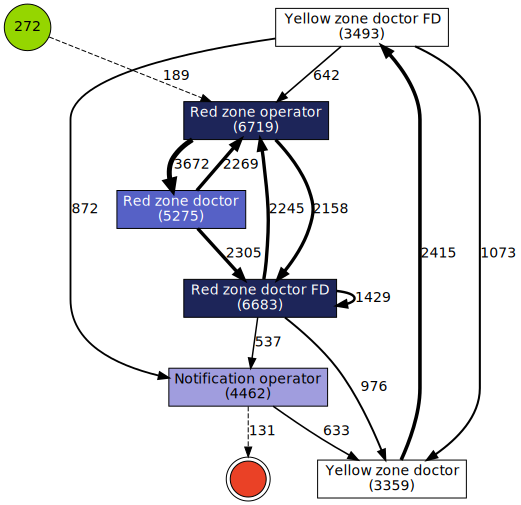

In [7]:
pm.render()

# FINAL EXECUTION HERE...!!!

### Fitness Calculation 

#### Activity is Varied (0-100) 
#### Path is Constant Steps (0,20,40,60,80,100)

In [11]:
Act = [] # Stores the ACT Figure
PATH_THRES = [5,20,40,60,80,100]


for outer_j in trange(len(PATH_THRES)):
    
    Act = [] # Stores the ACT Figure
    
    INDI_FIT = [] # Stores the Final State of 
    
    fitter = 0
        
    ID = []
  
    for count in trange(0,101,1):  
        
        MK = [] # Source Keys
        SK = [] # Destination Keys 
        
        # Net Assignment 
        
        INPUT = MINER(df1, count, PATH_THRES[outer_j]) # The Process MAP that is to be compared is entered here (Dataset is entered here) # MAP HERE
        
        MK = Key_SEGREGATOR(map_2_key(INPUT))[0].copy()
        SK = Key_SEGREGATOR(map_2_key(INPUT))[1].copy()
        
        MK, SK = START_END_DEL(MK,SK)
        
        
        
        if MK != []:
            
            P_MAP = ONE_D_Mapper(MK,SK)


            for i in range(len(ids)): # INDIVIDUAL LOOPING OF EACH ID

                df3 = df1[df1["case_id"] == ids[i]].reset_index(drop = True) # THE ID for each Dataset is mentioned here

                Trace = df3.copy() # ID CARRYING VARIABLE

                for j in range(len(Trace)):
                    Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE


            # GENERATION FROM THE LOG's SIDE     

                Pre_FIT = Wheeler(Trace, P_MAP)

                if len(Trace) == (sum(Pre_FIT)+1):
                    fitter+=1

                if i == len(ids)-1:
                    INDI_FIT.append((fitter/len(ids))*100) # 272 = len of ids
                    print("Fitness = ", (fitter/len(ids))*100)
                    fitter=0 # ReSETTING THE COUNTER

            Act.append(count)
        else:
            Act.append(count)
            INDI_FIT.append(0)
            print("Fitness =  0")
            
            
    if outer_j == 0:
        res_SA0 = pd.DataFrame({"Path_Rate":Act,"Fitness":INDI_FIT})

    elif outer_j == 1:
        res_SA1 = pd.DataFrame({"Path_Rate":Act,"Fitness":INDI_FIT})

    elif outer_j == 2:
        res_SA2 = pd.DataFrame({"Path_Rate":Act,"Fitness":INDI_FIT})

    elif outer_j == 3:
        res_SA3 = pd.DataFrame({"Path_Rate":Act,"Fitness":INDI_FIT})

    elif outer_j == 4:
        res_SA4 = pd.DataFrame({"Path_Rate":Act,"Fitness":INDI_FIT})

    elif outer_j == 5:
        res_SA5 = pd.DataFrame({"Path_Rate":Act,"Fitness":INDI_FIT})


    print("\n\n-----------------------------------------------------------------------------------------")                   
    print("-----------------------------------NEXT ID OVER HERE-------------------------------------\n\n")                   
    
    #print("\n\n Total Number of FIT executions are ", final_state, "out of a Total of", len(ids), "IDs")
    #print("Fitness Rating = :", (final_state/len(ids))*100)
    
ACT_FULL = res_SA0.copy()
ACT_FULL = ACT_FULL.merge(res_SA1, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_SA2, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_SA3, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_SA4, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_SA5, on='Path_Rate', how='right')

ACT_FULL.columns = ['Activity_Rate', 'Path = 5', 'Path = 20' ,'Path = 40', 'Path = 60','Path = 80','Path = 100']

ACT_FULL

  0%|                                                                                          | 0/101 [00:00<?, ?it/s]C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE


{'activities': 0, 'paths': 5}



  1%|▊                                                                                 | 1/101 [00:09<16:34,  9.95s/it]

Fitness =  0.0
{'activities': 1, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

  2%|█▌                                                                                | 2/101 [00:17<14:00,  8.48s/it]

Fitness =  0.0
{'activities': 2, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

  3%|██▍                                                                               | 3/101 [00:24<13:07,  8.03s/it]

Fitness =  0.0
{'activities': 3, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

  4%|███▏                                                                              | 4/101 [00:32<12:41,  7.85s/it]

Fitness =  0.0
{'activities': 4, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

  5%|████                                                                              | 5/101 [00:40<12:26,  7.78s/it]

Fitness =  1.1029411764705883
{'activities': 5, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

  6%|████▊                                                                             | 6/101 [00:47<12:17,  7.77s/it]

Fitness =  1.1029411764705883
{'activities': 6, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

  7%|█████▋                                                                            | 7/101 [00:55<11:55,  7.61s/it]

Fitness =  1.1029411764705883
{'activities': 7, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

  8%|██████▍                                                                           | 8/101 [01:02<11:31,  7.44s/it]

Fitness =  1.1029411764705883
{'activities': 8, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

  9%|███████▎                                                                          | 9/101 [01:09<11:17,  7.37s/it]

Fitness =  1.1029411764705883
{'activities': 9, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 10%|████████                                                                         | 10/101 [01:16<11:05,  7.31s/it]

Fitness =  1.1029411764705883
{'activities': 10, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 11%|████████▊                                                                        | 11/101 [01:23<10:50,  7.23s/it]

Fitness =  1.1029411764705883
{'activities': 11, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 12%|█████████▌                                                                       | 12/101 [01:30<10:36,  7.16s/it]

Fitness =  1.1029411764705883
{'activities': 12, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 13%|██████████▍                                                                      | 13/101 [01:37<10:25,  7.10s/it]

Fitness =  1.1029411764705883
{'activities': 13, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 14%|███████████▏                                                                     | 14/101 [01:44<10:15,  7.07s/it]

Fitness =  1.1029411764705883
{'activities': 14, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 15%|████████████                                                                     | 15/101 [01:51<10:07,  7.06s/it]

Fitness =  1.4705882352941175
{'activities': 15, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 16%|████████████▊                                                                    | 16/101 [01:58<09:57,  7.03s/it]

Fitness =  1.4705882352941175
{'activities': 16, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 17%|█████████████▋                                                                   | 17/101 [02:05<09:49,  7.01s/it]

Fitness =  1.4705882352941175
{'activities': 17, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 18%|██████████████▍                                                                  | 18/101 [02:12<09:41,  7.00s/it]

Fitness =  1.4705882352941175
{'activities': 18, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 19%|███████████████▏                                                                 | 19/101 [02:19<09:34,  7.00s/it]

Fitness =  2.5735294117647056
{'activities': 19, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 20%|████████████████                                                                 | 20/101 [02:26<09:28,  7.01s/it]

Fitness =  2.5735294117647056
{'activities': 20, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 21%|████████████████▊                                                                | 21/101 [02:33<09:20,  7.01s/it]

Fitness =  2.5735294117647056
{'activities': 21, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 22%|█████████████████▋                                                               | 22/101 [02:40<09:13,  7.01s/it]

Fitness =  2.5735294117647056
{'activities': 22, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 23%|██████████████████▍                                                              | 23/101 [02:47<09:08,  7.03s/it]

Fitness =  2.5735294117647056
{'activities': 23, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 24%|███████████████████▏                                                             | 24/101 [02:54<09:00,  7.02s/it]

Fitness =  2.5735294117647056
{'activities': 24, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 25%|████████████████████                                                             | 25/101 [03:01<08:54,  7.04s/it]

Fitness =  2.5735294117647056
{'activities': 25, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 26%|████████████████████▊                                                            | 26/101 [03:08<08:46,  7.02s/it]

Fitness =  2.5735294117647056
{'activities': 26, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 27%|█████████████████████▋                                                           | 27/101 [03:15<08:41,  7.05s/it]

Fitness =  2.5735294117647056
{'activities': 27, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 28%|██████████████████████▍                                                          | 28/101 [03:22<08:33,  7.03s/it]

Fitness =  2.5735294117647056
{'activities': 28, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 29%|███████████████████████▎                                                         | 29/101 [03:29<08:28,  7.06s/it]

Fitness =  2.5735294117647056
{'activities': 29, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 30%|████████████████████████                                                         | 30/101 [03:36<08:18,  7.02s/it]

Fitness =  2.5735294117647056
{'activities': 30, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

 31%|████████████████████████▊                                                        | 31/101 [03:44<08:13,  7.05s/it]

Fitness =  2.5735294117647056
{'activities': 31, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\3913433264.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE
  0%|                                                                                            | 0/6 [03:48<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
ACT_FULL.to_csv("Sample_5_Fitness_ACT.csv")

In [ ]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Activity_Rate', y='value', hue='variable', data=pd.melt(ACT_FULL, ['Activity_Rate']), lw = 2)
plt.xlabel("Activity (0-100%)")
plt.ylabel("Fitness Rating")
plt.title("Fitness - When Activity is Varied b/w (0 - 100 )& Path is kept Constant")
plt.show()

-----------

### Fitness 
#### Activites is Constant in Steps of [0,20,40,60,80,100] 
#### Path is varied between (0-100)

In [10]:
Path = [] # Stores the ACT Figure
ACT_THRES = [5,20,40,60,80,100]


for outer_j in trange(len(ACT_THRES)):
    
    Path = [] # Stores the ACT Figure
    
    INDI_FIT = [] # Stores the Final State of Fitness

    fitter = 0
    
    ID = []   
    
    for count in trange(0,101,1):  
        
        MK = [] # Source Keys
        SK = [] # Destination Keys 
        
        # Net Assignment 
        
        INPUT = MINER(df1, ACT_THRES[outer_j], count) # The Process MAP that is to be compared is entered here (Dataset is entered here) # MAP HERE
            
        MK = Key_SEGREGATOR(map_2_key(INPUT))[0].copy()
        SK = Key_SEGREGATOR(map_2_key(INPUT))[1].copy()
        
        MK, SK = START_END_DEL(MK,SK)
        

    
    #-------------------------------------------------------------------------------------------------------------------------
        
        if MK != []:
            
            
            P_MAP = ONE_D_Mapper(MK,SK)
            
                    
            for i in range(len(ids)): # INDIVIDUAL LOOPING OF EACH ID

                df3 = df1[df1["case_id"] == ids[i]].reset_index(drop = True) # THE ID for each Dataset is mentioned here

                Trace = df3.copy() # ID CARRYING VARIABLE

                for j in range(len(Trace)):
                    Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE
        
        
                # GENERATION FROM THE LOG's SIDE
                Pre_FIT = Wheeler(Trace, P_MAP)

                if len(Trace) == (sum(Pre_FIT)+1):
                    fitter+=1

                if i == len(ids)-1:
                    INDI_FIT.append((fitter/len(ids))*100) # 272 = len of ids
                    print("Fitness = ", (fitter/len(ids))*100)
                    fitter=0 # ReSETTING THE COUNTER

            Path.append(count)
        else:
            Path.append(count)
            INDI_FIT.append(0)
            print("Fitness =  0")
            
    if outer_j == 0:
        res_FA0 = pd.DataFrame({"Activity_Rate":Path,"Fitness":INDI_FIT})

    elif outer_j == 1:
        res_FA1 = pd.DataFrame({"Activity_Rate":Path,"Fitness":INDI_FIT})

    elif outer_j == 2:
        res_FA2 = pd.DataFrame({"Activity_Rate":Path,"Fitness":INDI_FIT})

    elif outer_j == 3:
        res_FA3 = pd.DataFrame({"Activity_Rate":Path,"Fitness":INDI_FIT})

    elif outer_j == 4:
        res_FA4 = pd.DataFrame({"Activity_Rate":Path,"Fitness":INDI_FIT})

    elif outer_j == 5:
        res_FA5 = pd.DataFrame({"Activity_Rate":Path,"Fitness":INDI_FIT})
        
        
        print("\n\n-----------------------------------------------------------------------------------------")                   
        print("-----------------------------------NEXT ID OVER HERE-------------------------------------\n\n")                   
    
    #print("\n\n Total Number of FIT executions are ", final_state, "out of a Total of", len(ids), "IDs")
    #print("Fitness Rating = :", (final_state/len(ids))*100)
    
Path_FULL = res_FA0.copy()
Path_FULL = Path_FULL.merge(res_FA1, on='Activity_Rate', how='right')
Path_FULL = Path_FULL.merge(res_FA2, on='Activity_Rate', how='right')
Path_FULL = Path_FULL.merge(res_FA3, on='Activity_Rate', how='right')
Path_FULL = Path_FULL.merge(res_FA4, on='Activity_Rate', how='right')
Path_FULL = Path_FULL.merge(res_FA5, on='Activity_Rate', how='right')

Path_FULL.columns = ['Path_Rate', 'Activity = 5', 'Activity = 20' ,'Activity = 40', 'Activity = 60','Activity = 80','Activity = 100']

Path_FULL

  0%|                                                                                          | 0/101 [00:00<?, ?it/s]C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\1666760191.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE


{'activities': 5, 'paths': 0}



  1%|▊                                                                                 | 1/101 [00:09<16:27,  9.88s/it]

Fitness =  1.1029411764705883
{'activities': 5, 'paths': 1}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\1666760191.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

  2%|█▌                                                                                | 2/101 [00:17<13:46,  8.35s/it]

Fitness =  1.1029411764705883
{'activities': 5, 'paths': 2}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\1666760191.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

  3%|██▍                                                                               | 3/101 [00:24<12:56,  7.92s/it]

Fitness =  1.1029411764705883
{'activities': 5, 'paths': 3}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\1666760191.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

  4%|███▏                                                                              | 4/101 [00:32<12:35,  7.78s/it]

Fitness =  1.1029411764705883
{'activities': 5, 'paths': 4}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\1666760191.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

  5%|████                                                                              | 5/101 [00:39<12:14,  7.66s/it]

Fitness =  1.1029411764705883
{'activities': 5, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_34424\1666760191.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trace["task"][j] = Filter(Trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE
  0%|                                                                                            | 0/6 [00:43<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
PATH_FULL.to_csv("Sample_5_Fitness_PATH.csv")

In [ ]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Path_Rate', y='value', hue='variable', data=pd.melt(Path_FULL, ['Path_Rate']), lw = 2)
plt.xlabel("Path (0-100%)")
plt.ylabel("Fitness Rating")
plt.title("Fitness - When Activity is Path is kept Constant & Varied b/w (0 - 100 )")
plt.show()